<a href="https://colab.research.google.com/github/anoopsanka/retinal_oct/blob/main/notebooks/OCT_MixtureModel_224_valsplit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
# needed to use rotate....
!pip install -U tensorflow_addons
!pip install -U wandb
!pip install envyaml
!git clone https://github.com/anoopsanka/retinal_oct

In [ ]:
%cd retinal_oct

/content/retinal_oct


Shuffling and writing examples to /root/tensorflow_datasets/retina_dataset/1.0.0.incompleteSTLGXZ/retina_dataset-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/retina_dataset/1.0.0.incompleteSTLGXZ/retina_dataset-test.tfrecord


Dataset retina_dataset downloaded and prepared to /root/tensorflow_datasets/retina_dataset/1.0.0. Subsequent calls will reuse this data.


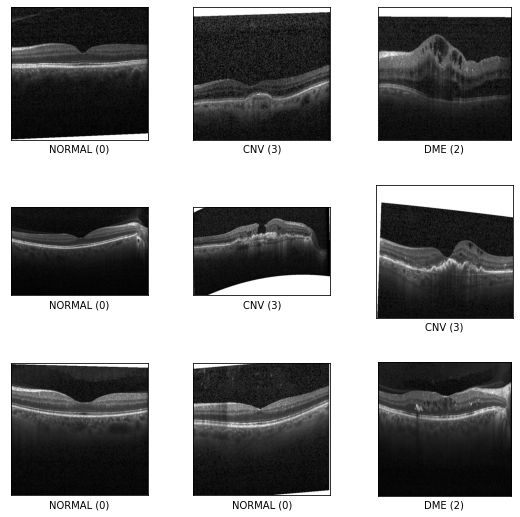

In [ ]:
import tensorflow_datasets as tfds
from importlib.util import find_spec
if find_spec("core") is None:
    import sys
    sys.path.append('..')
    
from core.datasets import RetinaDataset

ds_train, ds_train_info = tfds.load('RetinaDataset', split='train', shuffle_files=False, as_supervised=True, with_info=True)
ds_test                 = tfds.load('RetinaDataset', split='test',  shuffle_files=False, as_supervised=True)

fig = tfds.show_examples(ds_train, ds_train_info)

In [ ]:
import os
import random
import tensorflow as tf
import numpy as np
# Set the random seeds
os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)

In [ ]:
import numpy as np
from sklearn.semi_supervised import LabelSpreading
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap
from core.models.simclr_model import Pretrained_SimCLR_Model
import os

from core.datasets.data_augmentation import preprocess_image, preprocess_for_train
import tensorflow as tf

In [ ]:
!gdown --id 11tGjhW58pqvhILQVP2kM8Xbou2pyGR-n

In [ ]:
weight_file = "/content/retinal_oct/34_simclr_weights.73-1.00.hdf5"

In [ ]:
img_size = 224
resnet_depth = 34

model_loadweights = Pretrained_SimCLR_Model(resnet_depth=resnet_depth )
input_shape_base   = (None, img_size, img_size, 3)
input_shape_simclr = (None, img_size, img_size, 6)
model_loadweights.base_model.build(input_shape_base)
model_loadweights.build(input_shape_simclr)
model_loadweights.summary()
model_loadweights.load_weights(weight_file)



Model: "pretrained__sim_clr__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet (Resnet)              multiple                  21306048  
_________________________________________________________________
head_supervised (SupervisedH multiple                  2052      
_________________________________________________________________
projection_head (ProjectionH multiple                  594304    
Total params: 21,902,414
Trainable params: 21,882,948
Non-trainable params: 19,466
_________________________________________________________________


In [ ]:
def train_data_aug(img, lb):
  xs = []
  for _ in range(2):
    xs.append(preprocess_image(img, 
                               img_size, 
                               img_size, 
                               is_training=True, 
                               color_distort=True, 
                               test_crop=True))
  img = tf.concat(xs, -1)
  return img, tf.one_hot(lb, 4)

def train_data_aug_one(img, lb):
  img = preprocess_image(img, 
                         img_size, 
                         img_size, 
                         is_training=True, 
                         color_distort=True,
                         test_crop=True)
  return img, tf.one_hot(lb,4 )

# goal here is given some index
def resize_only(img, lb, img_size=224):
  img = tf.image.resize(img, (img_size,img_size))
  img = tf.cast(img, tf.float32) / 255.
  return img, tf.one_hot(lb, 4)

## SimCLR Model Performance

In [ ]:
total = 0
correct = 0
for X, y in ds_train.map(resize_only).batch(128):
  ypred = model_loadweights(X, training=False)
  correct += sum(y.numpy().argmax(-1) == ypred[1].numpy().argmax(-1))
  total   += len(y)
print(correct/total)

KeyboardInterrupt: ignored

In [ ]:
total = 0
correct = 0
for X, y in ds_train.map(train_data_aug_one).batch(128):
  ypred = model_loadweights(X, training=False)
  correct += sum(y.numpy().argmax(-1) == ypred[1].numpy().argmax(-1))
  total   += len(y)
print(correct/total)

# Save Local Embedding Files

In [ ]:
%mkdir embeddings

In [ ]:
def extract_embedding(model, 
                      dataset, 
                      save_dir = './embeddings'):
  """Extract the layers to np array"""
  all_train_proj = []
  all_train_logits = []
  all_train_labels = []

  for X, y in dataset.map(resize_only).batch(128):
    proj, logits = model.call(X, training=False)
    all_train_proj.append(proj.numpy())
    all_train_logits.append(logits.numpy())
    all_train_labels.append(y.numpy())

  all_train_proj_   = np.vstack(all_train_proj)
  all_train_logits_ = np.vstack(all_train_logits)
  all_train_labels_ = np.vstack(all_train_labels)

  np.save( os.path.join(save_dir, "train_proj.npy"), all_train_proj_)
  np.save( os.path.join(save_dir, 'train_logits.npy'), all_train_logits_)
  np.save( os.path.join(save_dir, 'train_labels.npy'), all_train_labels_)

In [ ]:
# get the last conv layer
# extract embedding

x = tf.keras.Input((img_size,img_size,3))
final_conv = model_loadweights.layers[0](x)
embedding_globalAvg = tf.keras.layers.GlobalAveragePooling2D()(final_conv)
model_global_embedding = tf.keras.Model(x, embedding_globalAvg)
all_train_resnet_embed = []

t = 0
for X, y in ds_train.map(train_data_aug_one).batch(128):
  embedding_resnet = model_global_embedding.call(X, training=False)
  all_train_resnet_embed.append(embedding_resnet.numpy())

all_train_resnet_embed_   = np.vstack(all_train_resnet_embed)

np.save('./embeddings/train_resnet_proj.npy', all_train_resnet_embed_)

In [ ]:
extract_embedding(model_loadweights, ds_train)

# Load the numpy embeddings

In [ ]:
all_train_proj   = np.load('./embeddings/train_proj.npy')
all_train_logits = np.load('./embeddings/train_logits.npy')
all_train_labels = np.load('./embeddings/train_labels.npy')
all_train_resnet_embed   = np.load('./embeddings/train_resnet_proj.npy')
all_train_proj_normed = all_train_proj / ((all_train_proj**2.0).sum(axis=-1, keepdims=True))**0.5

In [ ]:
def embedding_dimension_reduction(embedding, 
                                  labels, 
                                  reduced_dimension = 8, 
                                  method = 'UMAP',
                                  metric = 'cosine', 
                                  pairplot=False, 
                                  baseline_regression = False):

  if method == 'UMAP':
    reducer           = umap.UMAP(n_components= reduced_dimension, metric=metric,)
    reduced_embedding = reducer.fit_transform(embedding)
  elif method == 'PCA':
    reducer           = PCA(n_components= reduced_dimension, whiten=True)
    
    reduced_embedding = reducer.fit_transform(embedding)

  if pairplot:
    df = pd.DataFrame()
    for i in range(reduced_dimension):
      df[f'{method}{i+1}'] = reduced_embedding[:,i]
    df['class'] = labels
    sns.pairplot(df.sample(968), hue='class', palette='tab10', corner=True,)
  
  if baseline_regression:
    clf   = LogisticRegression( penalty='l2', max_iter=1000, class_weight='balanced').fit(reduced_embedding, labels)
    ypred = clf.predict(reduced_embedding)

    print(classification_report(labels, ypred))
    label_names_list = ds_train_info.features['label'].names
    plot_confusion_matrix(clf, 
                          reduced_embedding, 
                          labels, 
                          normalize='true', 
                          display_labels=label_names_list, 
                          cmap='inferno')

  return reduced_embedding

              precision    recall  f1-score   support

           0       0.87      0.80      0.83     26318
           1       0.39      0.63      0.48      8616
           2       0.78      0.80      0.79     11350
           3       0.94      0.85      0.89     37205

    accuracy                           0.80     83489
   macro avg       0.74      0.77      0.75     83489
weighted avg       0.84      0.80      0.82     83489



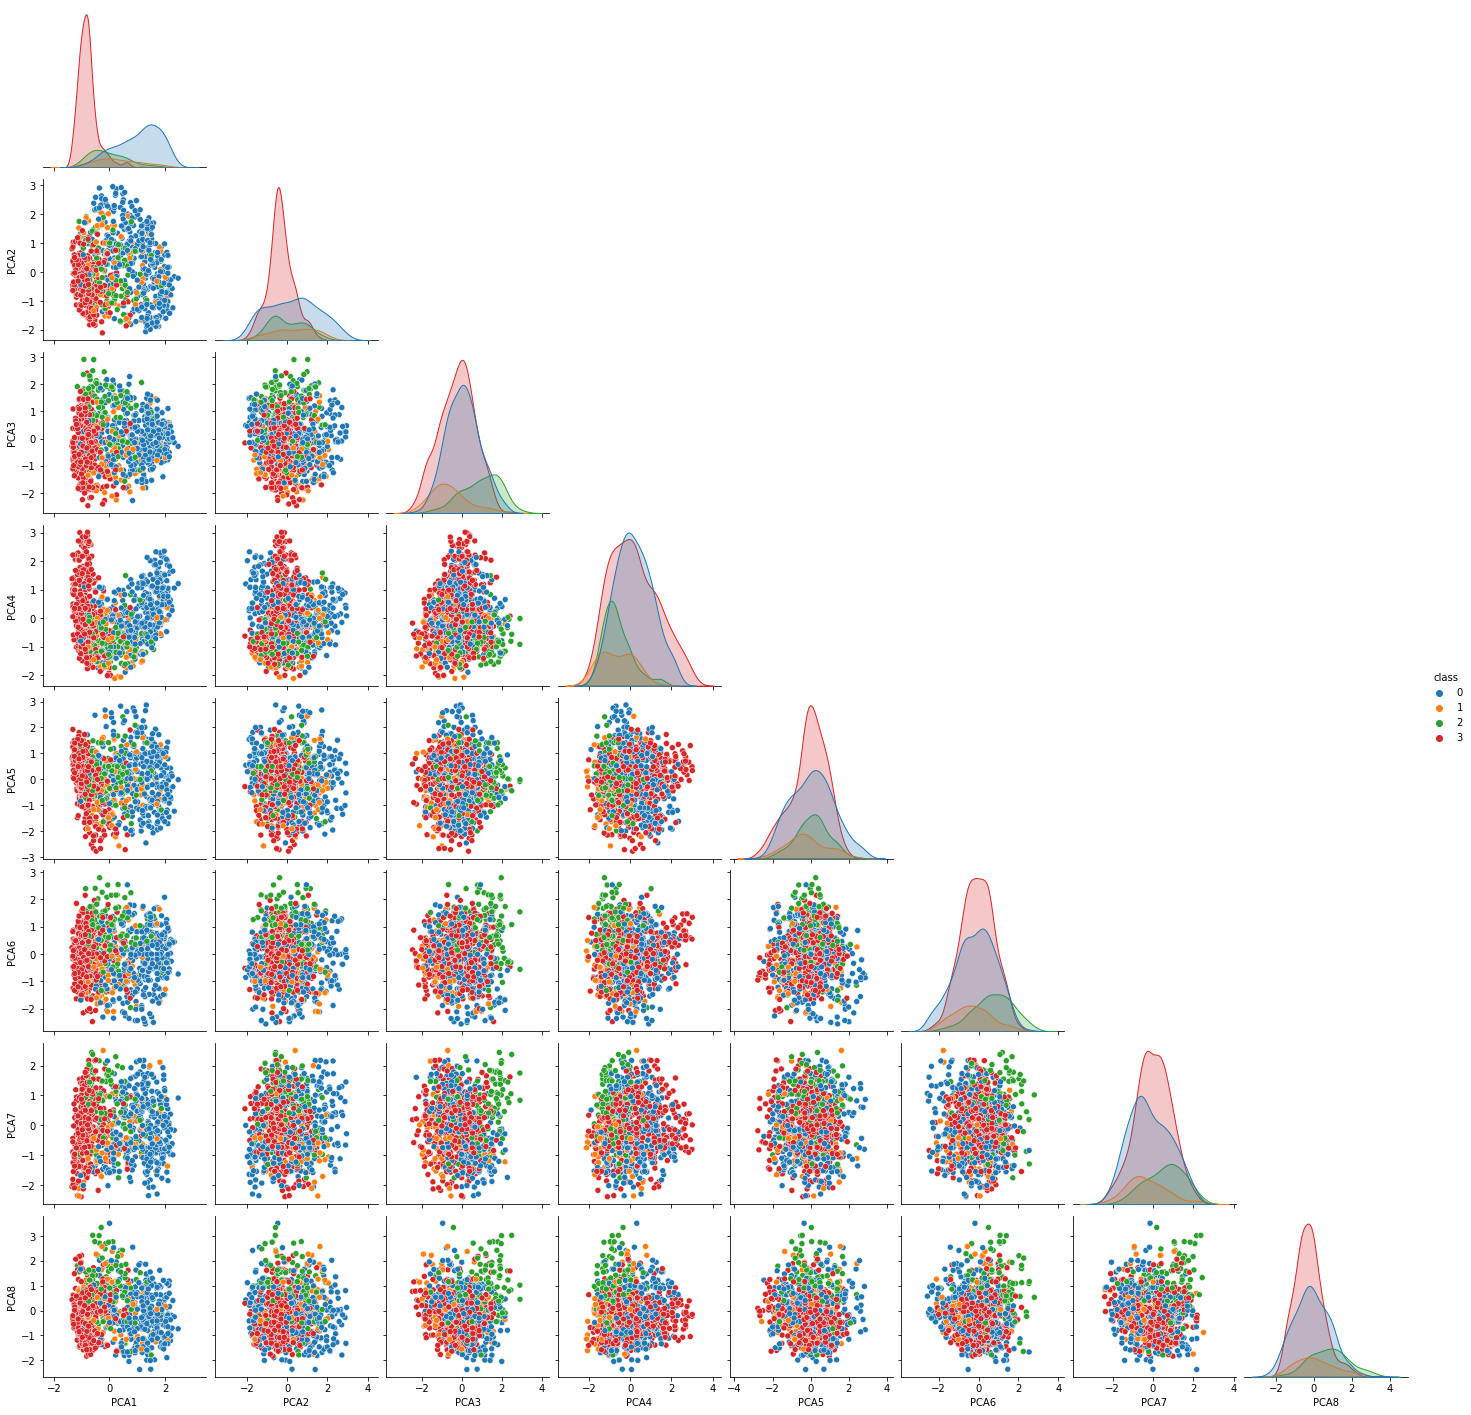

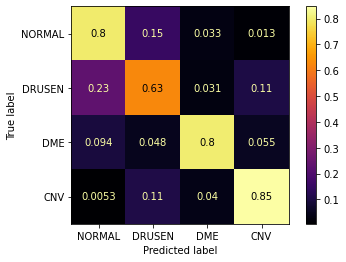

In [ ]:
resnet_proj_PCA = embedding_dimension_reduction(all_train_resnet_embed, 
                                                all_train_labels.argmax(-1), 
                                                method='PCA',
                                                reduced_dimension=8,
                                                pairplot=True,
                                                baseline_regression=True)

In [ ]:
# from yellowbrick.cluster import KElbowVisualizer

# # Generate synthetic dataset with 8 random clusters
# X, y = make_blobs(n_samples=1000, n_features=12, centers=8, random_state=42)

# # Instantiate the clustering model and visualizer
# model = KMeans()
# visualizer = KElbowVisualizer(
#     model, k=(4,12), metric='calinski_harabasz', timings=False
# )

# visualizer.fit(X)        # Fit the data to the visualizer
# visualizer.show()        # Finalize and render the figure

In [ ]:
resnet_proj_PCA = embedding_dimension_reduction(all_train_resnet_embed, 
                                                all_train_labels.argmax(-1), 
                                                method='PCA',
                                                reduced_dimension=8,
                                                pairplot=True,
                                                baseline_regression=True)

# Pure Label Smoothing

In [ ]:
def retrieve_images(index, batch_size=64):
  count = 0

  images = []
  labels = []

  index_test = index[:]

  counter = 1
  for X, y in ds_train.map(resize_only).batch(batch_size):

    current_batch_idx = index_test // (batch_size * counter)
    current_X_idx     = (index_test % batch_size)[current_batch_idx==0]
    
    images.append(X.numpy()[current_X_idx])
    labels.append(y.numpy()[current_X_idx].argmax(-1))

    # update the index_test to ignore batch that has been seen before
    index_test = index_test[current_batch_idx!=0]

    counter += 1
  return np.vstack(images), np.hstack(labels)

In [ ]:
def masked_labels_embedding(full_embedding, 
                            full_labels, 
                            sample_per_class = 1, 
                            max_sample_per_class = 1000):
  """retain only n sample per each class, masked the rest with label == -1
  Args:
    sample_per_class:     n labeled images per class
    max_sample_per_class: number of total sample per class
  Returns:
    embeddings, labeles_masked, labels_truth
  """
  # order the labels by the unique class
  unique_class     = 4

  embeddings_ordered = []
  labels_ordered     = []
  labels_masked      = []
  index_ordered      = []

  full_index = np.arange(len(full_embedding))
  for i in range(unique_class):
    flags = (full_labels == i)

    index = full_index[flags][:max_sample_per_class]

    # index = np.random.choice(full_index[flags], size=max_sample_per_class, replace=False)

    embeddings_ordered.append(full_embedding[index])
    labels_ordered.append(full_labels[index])


    idx = np.random.randint(0, max_sample_per_class,size=sample_per_class, )
    ones = np.ones(max_sample_per_class, )*-1
    ones[idx] = i
    labels_masked.append(ones)

    index_ordered.append(index)

  labels_masked = np.hstack(labels_masked).astype(int)
  labels_ordered = np.hstack(labels_ordered).astype(int)
  embeddings_ordered = np.vstack(embeddings_ordered)

  return embeddings_ordered, labels_masked, labels_ordered, index_ordered

# repeat label spreading n times to get uncertain labels
def fit_labelSpreading(embedding, partial_labels):
  model_lb_spread = LabelSpreading(kernel='rbf', alpha=0.1,)
  model_lb_spread.fit(embedding, partial_labels )
  return model_lb_spread.transduction_

def run_labelSpreading(embedding, labels, sample_per_class = 1, max_sample_per_class = 4000, ntimes = 10):
  ground_truth     = []
  predicted_labels = []
  for k in range(ntimes):
    partial_embedding, partial_label, truth_label, index = masked_labels_embedding(embedding, 
                                                                    labels, 
                                                                    sample_per_class = sample_per_class, 
                                                                    max_sample_per_class = max_sample_per_class)
    pred_labels = fit_labelSpreading(partial_embedding, partial_label)

    predicted_labels.append(pred_labels)
    ground_truth.append(truth_label)

  labels_pred_stacked = np.vstack(predicted_labels)
  label_vote = []

  for l in range(4):
    label_vote.append( (labels_pred_stacked == l).sum(axis=0))
  label_vote = np.vstack(label_vote)

  return label_vote, pred_labels, ground_truth, index

def select_uncertain_images(votes, images, labels, max_vote = 5):

  vote_count = votes.max(0)

  img_selected = images[vote_count < max_vote]
  lb_selected  = labels[vote_count < max_vote]
  return img_selected, lb_selected

In [ ]:
def train_classification_model(train_dataset, 
                               val_dataset, 
                               img_size = 224, 
                               epochs = 50,
                               weight_file = weight_file):
  model = Pretrained_SimCLR_Model( resnet_depth=34 )
  input_shape_base   = (None, img_size, img_size, 3)
  input_shape_simclr = (None, img_size, img_size, 6)
  model.base_model.build(input_shape_base)
  model.build(input_shape_simclr)
  model.summary()
  model.load_weights(weight_file)


  input_layer   = tf.keras.Input((img_size, img_size,3))
  resnet_output = model.layers[0](input_layer)
  hidden        = tf.keras.layers.GlobalAveragePooling2D()(resnet_output)
  output        = tf.keras.layers.Dense(4, activation='softmax')(hidden)

  model_retrain = tf.keras.Model(input_layer, output)
  model_retrain.layers[1].trainable = False

  # optimizer = tf.keras.optimizers.Adam(1e-3)
  model_retrain.compile(loss = 'categorical_crossentropy', 
                        metrics=['accuracy'])
  model_retrain.summary()

  history = model_retrain.fit(train_dataset, 
                  validation_data = val_dataset, 
                  callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                                patience=3, 
                                                                restore_best_weights=True)],
                  epochs=epochs)
  
  print('-----------------------------------------------')
  model_retrain.evaluate(ds_test.map(resize_only).batch(32))
  print('-----------------------------------------------')

  model_retrain.layers[1].trainable = True
  optimizer = tf.keras.optimizers.Adam(1e-5)
  model_retrain.compile(loss = 'categorical_crossentropy',
                        optimizer = optimizer ,
                        metrics=['accuracy'])
  model_retrain.summary()

  history = model_retrain.fit(train_dataset, 
                  validation_data = val_dataset, 
                  callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                                patience=10,
                                                                restore_best_weights=True)],
                  epochs=epochs)
  print('-----------------------------------------------')
  model_retrain.evaluate(ds_test.map(resize_only).batch(32))
  print('-----------------------------------------------')

  
  return model_retrain, history


from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_image_function(img):
  return preprocess_for_train(img, img_size, img_size, color_distort=True).numpy()

def prepare_partial_dataset(img, lb, 
                            sample_weight=False, 
                            val_split = 0.2):

  datagen = ImageDataGenerator(
      rotation_range=45,
      width_shift_range=0.2,
      height_shift_range=0.2, 
      horizontal_flip=True,) # preprocessing_function = preprocess_image_function)
  
  val_datagen = ImageDataGenerator(
  )

  onehot_lb = np.zeros((lb.size, lb.max()+1))
  onehot_lb[np.arange(lb.size), lb] = 1

  nval_per_class = int(len(lb)*val_split // 4)

  val_indx = []
  for i in range(4):
    idx = np.arange(len(lb))[lb == i]
    val_indx += [np.random.choice(idx , replace=False, size=nval_per_class )]
  val_indx = np.hstack(val_indx)

  Xval,   yval   = img[val_indx], onehot_lb[val_indx]
  Xtrain, ytrain = np.delete(img, val_indx, axis=0), np.delete(onehot_lb, val_indx, axis=0)

  if sample_weight:
    w = np.bincount(ytrain.argmax(-1))
    w = w.min() / w
    sample_weight = [w[i] for i in ytrain.argmax(-1)]
  else:
    sample_weight = np.ones_like(ytrain.argmax(-1))


  train_data_generator = datagen.flow(
      Xtrain,
      y=ytrain,
      batch_size=32,
      shuffle=True,
      sample_weight = sample_weight,
      seed=42,
      )
  
  test_data_generator = datagen.flow(
    Xval,
    y=yval,
    batch_size=32,
    shuffle=True,
    seed=42,
    )
  return train_data_generator, test_data_generator


def extract_embedding(finetuned_model, dataset, layer_index = -1,):
  inputs = tf.keras.Input((224,224,3))
  x = inputs
  for l in finetuned_model.layers[:3]:
    x = l(x)

  tmp_model = tf.keras.Model(inputs, x)
  tmp_model.summary()

  embeddings  = []
  test_labels = []
  for X, y in dataset.map(resize_only).batch(32):
    embeddings.append(tmp_model.call(X, training=False).numpy())
    test_labels.append(y.numpy())
  return np.vstack(embeddings), np.vstack(test_labels).argmax(-1)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

In [ ]:
def sample_labeled_data_with_mask(embedding, 
                                  labels, 
                                  masks, 
                                  sample_per_class=1):
  unique_class = np.unique(labels)
  global_index = np.arange(len(embedding))[masks]

  local_embed  = embedding[global_index]
  local_labels = labels[global_index]

  global_index_output = []
  embedding_output    = []
  labels_masked       = []
  ground_truth        = []

  for i in range(len(unique_class)):
    index_pure_class = (local_labels == i)
    embed_pure_class = local_embed[index_pure_class]
    label_pure_class = local_labels[index_pure_class]

    num_samples = sum(index_pure_class)

    idx = np.random.randint(0, num_samples,size=sample_per_class)
    ones = np.ones(num_samples, )*-1
    ones[idx] = i
    labels_masked.append(ones)

    global_index_output.append(global_index[index_pure_class])
    embedding_output.append(embed_pure_class)
    ground_truth.append(label_pure_class)

  return np.vstack(embedding_output), np.hstack(labels_masked), np.hstack(ground_truth), np.hstack(global_index_output)

def run_labelSpreading_withMask(embedding, 
                                labels, 
                                masks,
                                sample_per_class = 1, 
                                ntimes = 10):
  ground_truth     = []
  predicted_labels = []
  for k in range(ntimes):
    partial_embedding, partial_labels, partial_truth, partial_index = sample_labeled_data_with_mask(embedding, labels)

    pred_labels = fit_labelSpreading(embedding, labels, masks)

    predicted_labels.append(pred_labels)
    ground_truth.append(truth_label)

  labels_pred_stacked = np.vstack(predicted_labels)
  label_vote = []

  for l in range(4):
    label_vote.append( (labels_pred_stacked == l).sum(axis=0))
  label_vote = np.vstack(label_vote)

  return label_vote, pred_labels, ground_truth, index

def run_experiments_GaussianMixture_lb(embedding, 
                                        labels, 
                                        ntimes = 10,
                                        max_vote = 5,
                                        sample_per_class = 1,
                                        n_clusters=4, 
                                        n_dimension = 3,
                                        min_proba = 0.3,
                                        max_proba = 0.7,
                                       val_split = 0.1,
                                       sample_weight = True,
                                        ):
  X = embedding[:, :n_dimension]
  gmm_results = GaussianMixture(n_components=4, n_init=10).fit(X)

  pred_cluster = gmm_results.predict(X)
  train_labels = labels.argmax(-1)


  gmm_pred = gmm_results.predict_proba(X)
  flag1 = np.logical_and(gmm_pred[:,0] < max_proba, gmm_pred[:,0] > min_proba )
  flag2 = np.logical_and(gmm_pred[:,1] < max_proba, gmm_pred[:,1] > min_proba )
  flag3 = np.logical_and(gmm_pred[:,2] < max_proba, gmm_pred[:,2] > min_proba )
  flag4 = np.logical_and(gmm_pred[:,3] < max_proba, gmm_pred[:,3] > min_proba )

  _flags = np.logical_or.reduce((flag1, flag2, flag3, flag4))
  _index = np.arange(len(_flags))[_flags]

  f, ax = plt.subplots(2,2)
  ax = ax.flat
  ax[0].scatter(X[:,0][_flags], X[:,1][_flags], c = train_labels[_flags], cmap='viridis')
  ax[1].scatter(X[:,0][_flags], X[:,1][_flags], c = pred_cluster[_flags], cmap='viridis')

  ax[0].set_title('true labels')
  ax[1].set_title('cluster labels')

  ax[2].hist(train_labels[_flags])
  ax[3].hist(pred_cluster[_flags])
  plt.show()

  
  # filter out images that are classified as outlier in KMeans

  print('running label smoothing')
  # run label smoothing
  predicted_labels = []

  preselected_idx = []
  for i in range(ntimes):
    subsample_embed, subsample_masked_lb, subsample_gt, subsample_global_index = sample_labeled_data_with_mask(X, 
                                                                                                              train_labels, 
                                                                                                              _flags, 
                                                                                                              sample_per_class=sample_per_class,
                                                                                                              )
    preselected_idx.append( subsample_global_index[subsample_masked_lb > -1])

    print(train_labels[preselected_idx[-1]] )

    pred_lb = fit_labelSpreading(subsample_embed, subsample_masked_lb)
    predicted_labels.append(pred_lb)
  labels_pred_stacked = np.vstack(predicted_labels)
  label_vote = []

  for l in range(4):
    label_vote.append( (labels_pred_stacked == l).sum(axis=0))
  label_vote = np.vstack(label_vote)

  # select the images based on the uncertainty of votes
  # img_selected, lb_selected = select_uncertain_images(label_vote, 
  #                                                     images, 
  #                                                     labels, 
  #                                                     max_vote=max_vote)
  
  print('retrieving images')
  max_num_vote   = label_vote.max(0)
  index_selected = subsample_global_index[max_num_vote < max_vote]
  img_selected, lb_selected = retrieve_images(index_selected)

  print('retrieving images')
  preselected_idx = np.hstack(preselected_idx)
  img_certain, lb_certain   = retrieve_images(preselected_idx)
  # select some images based on pseudo labels

  print('uncertain')
  print(img_selected.shape)
  print(np.bincount(lb_selected))

  print('certain pseudo label')
  print(img_certain.shape)
  print(np.bincount(lb_certain))

  imgs, lbs = np.vstack([img_selected, img_certain]), np.hstack([lb_selected, lb_certain])

  print(imgs.shape, lbs.shape)

  # train and finetune the classification model
  ds_train, ds_val = prepare_partial_dataset(imgs, 
                                             lbs, 
                                             sample_weight=sample_weight, )

  model_gmm, history_gmm = train_classification_model(ds_train, ds_val)
  return model_gmm, history_gmm

# Gaussian Mixture Model
- with 4 components
- compute the z score for each data point with respect to each gaussian component
- $\rm{diag}\sqrt{( (x - \mu)^T\Sigma^{-1} (x - \mu) )}$
- taken data points that are 3 sigma away from the cluster center

# GMM uncertain label

In [ ]:
from sklearn.mixture import GaussianMixture

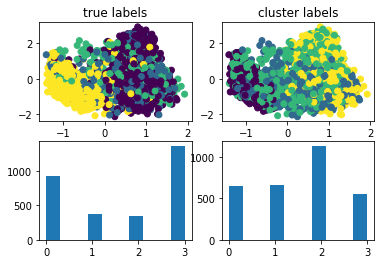

running label smoothing
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
retrieving images
retrieving images
uncertain
(1349, 224, 224, 3)
[594 208 248 299]
certain pseudo label
(80, 224, 224, 3)
[20 20 20 20]
(1429, 224, 224, 3) (1429,)
Model: "pretrained__sim_clr__model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet_1 (Resnet)            multiple                  21306048  
_________________________________________________________________
head_supervised (SupervisedH multiple                  2052      
_________________________________________________________________
projection_head_1 (Projectio multiple                  594304    
Total params: 21,902,414
Trainable params: 21,882,948
Non-trainable params: 19,466
____________________________

In [ ]:
model_gmm_pca, history_gmm_pca = run_experiments_GaussianMixture_lb(resnet_proj_PCA, 
                                                            all_train_labels,
                                                            sample_weight = True,
                                                            n_dimension = 8,
                                                            min_proba = 0.4, 
                                                            max_proba = 0.6,
                                                            ntimes = 20,
                                                            max_vote = 10,)

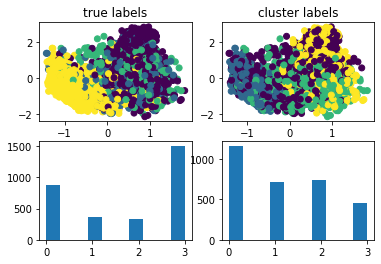

running label smoothing
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
retrieving images
retrieving images
uncertain
(1837, 224, 224, 3)
[770 311 273 483]
certain pseudo label
(80, 224, 224, 3)
[20 20 20 20]
(1917, 224, 224, 3) (1917,)
Model: "pretrained__sim_clr__model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet_2 (Resnet)            multiple                  21306048  
_________________________________________________________________
head_supervised (SupervisedH multiple                  2052      
_________________________________________________________________
projection_head_2 (Projectio multiple                  594304    
Total params: 21,902,414
Trainable params: 21,882,948
Non-trainable params: 19,466
____________________________

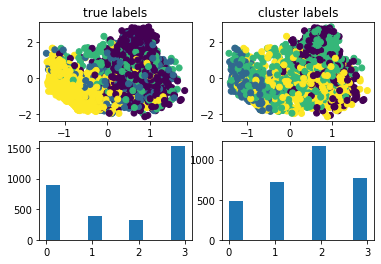

running label smoothing
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]


/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
retrieving images
retrieving images
uncertain
(2025, 224, 224, 3)
[792 304 297 632]
certain pseudo label
(80, 224, 224, 3)
[20 20 20 20]
(2105, 224, 224, 3) (2105,)
Model: "pretrained__sim_clr__model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet_3 (Resnet)            multiple                  21306048  
_________________________________________________________________
head_supervised (SupervisedH multiple                  2052      
_________________________________________________________________
projection_head_3 (Projectio multiple                  594304    
Total params: 21,902,414
Trainable params: 21,882,948
Non-trainable params: 19,466
_________________________________________________________________
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape  

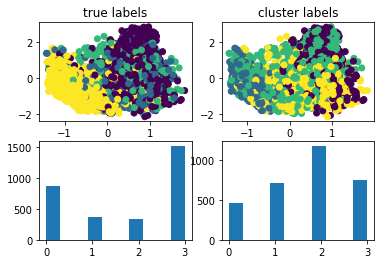

running label smoothing
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
retrieving images
retrieving images
uncertain
(1495, 224, 224, 3)
[571 226 225 473]
certain pseudo label
(80, 224, 224, 3)
[20 20 20 20]
(1575, 224, 224, 3) (1575,)
Model: "pretrained__sim_clr__model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet_4 (Resnet)            multiple                  21306048  
_________________________________________________________________
head_supervised (SupervisedH multiple                  2052      
_________________________________________________________________
projection_head_4 (Projectio multiple                  594304    
Total params: 21,902,414
Trainable params: 21,882,948
Non-trainable params: 19,466
____________________________

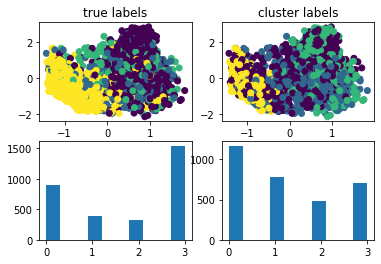

running label smoothing
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]


/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
retrieving images
retrieving images
uncertain
(1839, 224, 224, 3)
[729 306 269 535]
certain pseudo label
(80, 224, 224, 3)
[20 20 20 20]
(1919, 224, 224, 3) (1919,)
Model: "pretrained__sim_clr__model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet_5 (Resnet)            multiple                  21306048  
_________________________________________________________________
head_supervised (SupervisedH multiple                  2052      
_________________________________________________________________
projection_head_5 (Projectio multiple                  594304    
Total params: 21,902,414
Trainable params: 21,882,948
Non-trainable params: 19,466
_________________________________________________________________
Model: "model_4"
_________

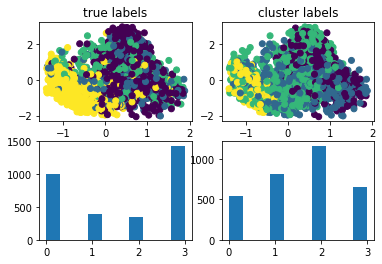

running label smoothing
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]


/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
retrieving images
retrieving images
uncertain
(1338, 224, 224, 3)
[692 202 235 209]
certain pseudo label
(80, 224, 224, 3)
[20 20 20 20]
(1418, 224, 224, 3) (1418,)
Model: "pretrained__sim_clr__model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet_6 (Resnet)            multiple                  21306048  
_________________________________________________________________
head_supervised (SupervisedH multiple                  2052      
_________________________________________________________________
projection_head_6 (Projectio multiple                  594304    
Total params: 21,902,414
Trainable params: 21,882,948
Non-trainable params: 19,466
_________________________________________________________________
Model: "model_5"
_____________________________

In [ ]:
all_history = []
for i in range(5):
  model_gmm_pca, history_gmm_pca = run_experiments_GaussianMixture_lb(resnet_proj_PCA, 
                                                              all_train_labels,
                                                              sample_weight = True,
                                                              n_dimension = 8,
                                                              min_proba = 0.4, 
                                                              max_proba = 0.6,
                                                              ntimes = 20,
                                                              max_vote = 10,)
  model_gmm_pca.save_weights(f"/content/drive/MyDrive/fourthbrain-ai/simclr_modelweights/final_pcad8_{i}_model_gmm_proba_0.4-0.6.h5")
  all_history.append(history_gmm_pca)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
input_6 (InputLayer)         multiple                  0         
_________________________________________________________________
resnet_6 (Resnet)            (None, 7, 7, 512)         21306048  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 512)               0         
Total params: 21,306,048
Trainable params: 21,288,896
Non-trainable params: 17,152
_________________________________________________________________
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       242
           1       0.98      0.78      0.87       242
           2       1.00      0.98      0.99       242
           3       0.84

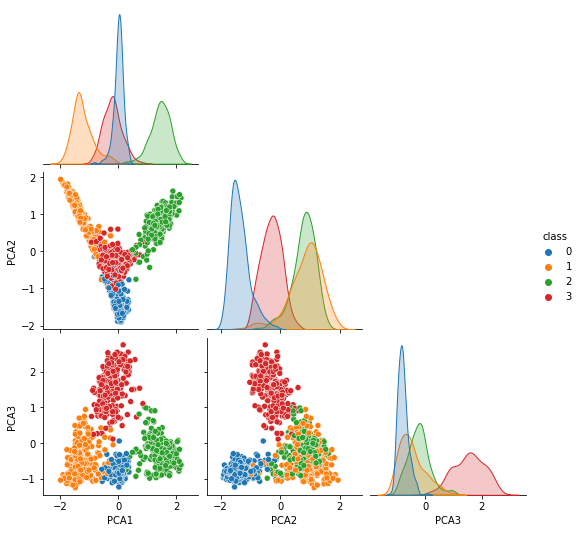

In [ ]:
gmm_uncertain_pred = model_gmm_pca.predict(ds_test.map(resize_only).batch(32))
embed, ground_truth = extract_embedding(model_gmm_pca, ds_test)
embedding_dimension_reduction(embed, ground_truth, method='PCA', pairplot=True, reduced_dimension=3)
print(classification_report(ground_truth, gmm_uncertain_pred.argmax(-1)))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.mixture import GaussianMixture
import seaborn as sns

def get_confusion_matrix(ground_truth, predictions):
  cof_mat = confusion_matrix(ground_truth, predictions)
  df = pd.DataFrame(cof_mat, columns= ds_train_info.features['label'].names )
  df.index = df.columns
  sns.heatmap(df, annot=True, fmt = ".3g")
  plt.show()

In [ ]:
all_history = []
for i in range(5):
  model_gmm_pca, history_gmm_pca = run_experiments_GaussianMixture_lb(resnet_proj_PCA, 
                                                              all_train_labels,
                                                              sample_weight = True,
                                                              n_dimension = 8,
                                                              min_proba = 0., 
                                                              max_proba = 0.73,
                                                              ntimes = 20,
                                                              max_vote = 10,)
  model_gmm_pca.save_weights(f"/content/drive/MyDrive/fourthbrain-ai/simclr_modelweights/retry_{i}_model_gmm_proba_0.3-0.7.h5")
  all_history.append(history_gmm_pca)

# Load the pretrained weights and Evaluate

In [ ]:
img_size = 224
model = Pretrained_SimCLR_Model( resnet_depth=34 )
input_shape_base   = (None, img_size, img_size, 3)
input_shape_simclr = (None, img_size, img_size, 6)
model.base_model.build(input_shape_base)
model.build(input_shape_simclr)
model.summary()
model.load_weights(weight_file)




Model: "pretrained__sim_clr__model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet_2 (Resnet)            multiple                  21306048  
_________________________________________________________________
head_supervised (SupervisedH multiple                  2052      
_________________________________________________________________
projection_head_2 (Projectio multiple                  594304    
Total params: 21,902,414
Trainable params: 21,882,948
Non-trainable params: 19,466
_________________________________________________________________
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet_2 (Resnet)            (None, 7, 7, 512)         21306048  
____

In [ ]:
def load_model(weights):  

  input_layer   = tf.keras.Input((img_size, img_size,3))
  resnet_output = model.layers[0](input_layer)
  hidden        = tf.keras.layers.GlobalAveragePooling2D()(resnet_output)
  output        = tf.keras.layers.Dense(4, activation='softmax')(hidden)

  model_retrain = tf.keras.Model(input_layer, output)
  model_retrain.compile(loss='categorical_crossentropy', metrics='accuracy')
  model_retrain.load_weights(weights)

  ypred, ytrue = [], []
  for X, y in ds_test.map(resize_only).batch(32):
    ypred.append(model_retrain.predict(X).argmax(-1))
    ytrue.append(y.numpy().argmax(-1))

  ytrue = np.hstack(ytrue)
  ypred = np.hstack(ypred)

  model_retrain.evaluate(ds_test.map(resize_only).batch(32))

  return model_retrain, ypred, ytrue

In [ ]:
weight_file_list = [f"/content/drive/MyDrive/fourthbrain-ai/simclr_modelweights/final_pcad8_{i}_model_gmm_proba_0.4-0.6.h5" for i in range(5)]

31/31 [==============================] - 3s 47ms/step - loss: 0.0952 - accuracy: 0.9718
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       242
           1       1.00      0.93      0.96       242
           2       0.99      0.98      0.98       242
           3       0.94      0.99      0.97       242

    accuracy                           0.97       968
   macro avg       0.98      0.97      0.97       968
weighted avg       0.98      0.97      0.97       968



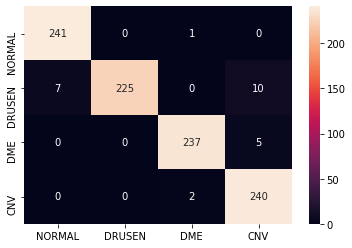

31/31 [==============================] - 3s 48ms/step - loss: 0.1180 - accuracy: 0.9643
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       242
           1       0.98      0.93      0.95       242
           2       1.00      0.97      0.98       242
           3       0.94      1.00      0.97       242

    accuracy                           0.97       968
   macro avg       0.97      0.97      0.97       968
weighted avg       0.97      0.97      0.97       968



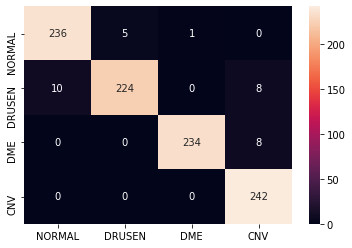

31/31 [==============================] - 3s 48ms/step - loss: 0.1857 - accuracy: 0.9345
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       242
           1       1.00      0.85      0.92       242
           2       0.99      0.92      0.95       242
           3       0.83      1.00      0.91       242

    accuracy                           0.94       968
   macro avg       0.95      0.94      0.94       968
weighted avg       0.95      0.94      0.94       968



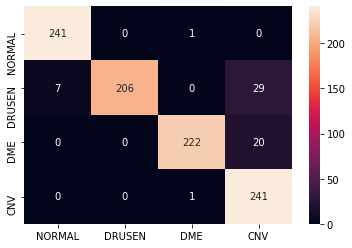

31/31 [==============================] - 3s 48ms/step - loss: 0.0757 - accuracy: 0.9790
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       242
           1       0.99      0.97      0.98       242
           2       0.98      0.97      0.97       242
           3       0.96      0.99      0.97       242

    accuracy                           0.98       968
   macro avg       0.98      0.98      0.98       968
weighted avg       0.98      0.98      0.98       968



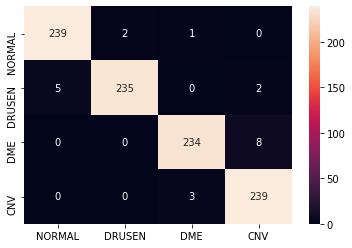

31/31 [==============================] - 3s 48ms/step - loss: 0.1442 - accuracy: 0.9430
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       242
           1       0.98      0.78      0.87       242
           2       1.00      0.98      0.99       242
           3       0.84      1.00      0.91       242

    accuracy                           0.93       968
   macro avg       0.94      0.93      0.93       968
weighted avg       0.94      0.93      0.93       968



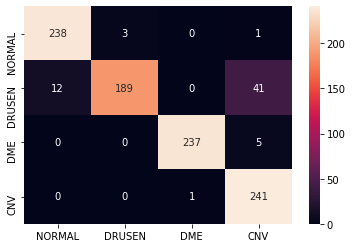

In [ ]:
for f in weight_file_list:
  print('=========================================================')
  model_reload, ypred, ytrue = load_model(f)
  print(classification_report(ytrue, ypred))
  get_confusion_matrix(ytrue, ypred)
  print('=========================================================')

In [ ]:
model_reload, ypred, ytrue = load_model(weight_file_list[3])

31/31 [==============================] - 3s 47ms/step - loss: 0.0757 - accuracy: 0.9790


Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
input_15 (InputLayer)        multiple                  0         
_________________________________________________________________
resnet_2 (Resnet)            (None, 7, 7, 512)         21306048  
_________________________________________________________________
global_average_pooling2d_14  (None, 512)               0         
Total params: 21,306,048
Trainable params: 21,288,896
Non-trainable params: 17,152
_________________________________________________________________
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       242
           1       0.99      0.97      0.98       242
           2       0.98      0.97      0.97       242
           3       0.9

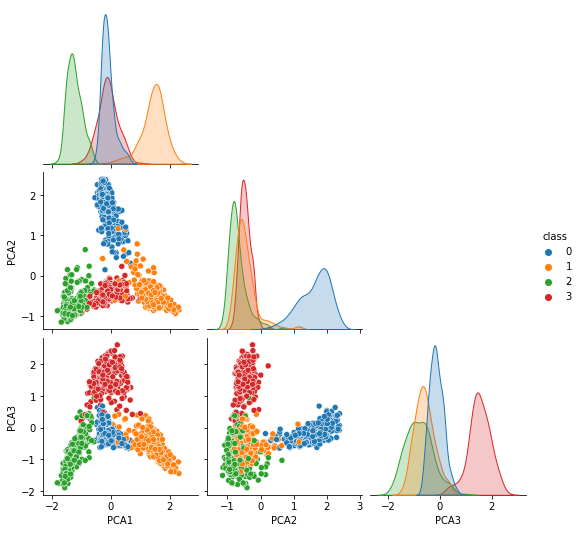

In [ ]:
pred = model_reload.predict(ds_test.map(resize_only).batch(32))
embed, ground_truth = extract_embedding(model_reload, ds_test)
embedding_dimension_reduction(embed, ground_truth, method='PCA', pairplot=True, reduced_dimension=3)
print(classification_report(ground_truth, pred.argmax(-1)))

In [ ]:
acc.mean(), acc.std()

(0.95852, 0.017011925229085633)

In [ ]:
len(ds_train)

83489

In [ ]:
tmp = [0.022,0.024,0.018,0.022,0.016]

In [ ]:
np.std(tmp), np.mean(tmp)

(0.002939387691339814, 0.020399999999999998)

In [ ]:
%pip install tf-explain

     |████████████████████████████████| 51kB 3.4MB/s 


In [ ]:
import tf_explain

def generate_ponderated_output(outputs, grads):
    """
    Apply Grad CAM algorithm scheme.

    Inputs are the convolutional outputs (shape WxHxN) and gradients (shape WxHxN).
    From there:
        - we compute the spatial average of the gradients
        - we build a ponderated sum of the convolutional outputs based on those averaged weights

    Args:
        output (tf.Tensor): Target layer outputs, with shape (batch_size, Hl, Wl, Nf),
            where Hl and Wl are the target layer output height and width, and Nf the
            number of filters.
        grads (tf.Tensor): Guided gradients with shape (batch_size, Hl, Wl, Nf)

    Returns:
        List[tf.Tensor]: List of ponderated output of shape (batch_size, Hl, Wl, 1)
    """

    maps = [
        ponderate_output(output, grad)
        for output, grad in zip(outputs, grads)
    ]

    return maps

def ponderate_output(output, grad):
    """
    Perform the ponderation of filters output with respect to average of gradients values.

    Args:
        output (tf.Tensor): Target layer outputs, with shape (Hl, Wl, Nf),
            where Hl and Wl are the target layer output height and width, and Nf the
            number of filters.
        grads (tf.Tensor): Guided gradients with shape (Hl, Wl, Nf)

    Returns:
        tf.Tensor: Ponderated output of shape (Hl, Wl, 1)
    """
    weights = tf.reduce_mean(grad, axis=(0, 1))

    # Perform ponderated sum : w_i * output[:, :, i]
    cam = tf.reduce_sum(tf.multiply(weights, output), axis=-1)

    return cam

def get_grad_model(base_model):
  x = tf.keras.Input((224,224,3))
  resnet_output = base_model.layers[1](x)
  out = tf.keras.layers.GlobalAveragePooling2D()(resnet_output)
  out = model_loadweights.layers[1](out)

  grad_model = tf.keras.Model(x, [resnet_output, out])
  return grad_model

def get_saliency_map(images, class_index, grad_model):
  # images = [image]
  # class_index = y[23]

  with tf.GradientTape() as tape:
    inputs = tf.cast(images, tf.float32)
    conv_outputs, predictions = grad_model(inputs)
    loss = predictions[:, class_index]
  grads = tape.gradient(loss, conv_outputs)

  guided_grads = (
    tf.cast(conv_outputs > 0, "float32") * tf.cast(grads > 0, "float32") * grads
  )

  cams = generate_ponderated_output(conv_outputs, guided_grads)

  heatmaps = np.array(
      [
          # not showing the actual image if image_weight=0
          heatmap_display(cam.numpy(), image,)
          for cam, image in zip(cams, images)
      ]
  )
  grid = grid_display(heatmaps)
  return grid

from scipy.special import softmax
from tf_explain.utils.display import heatmap_display, grid_display
import matplotlib.pyplot as plt

def explain_predictions(image, label, classification_model, grad_model,):
    IMG_SIZE = 224
    label_name = label_names_list[label]
    resized_img = tf.image.resize(image, (IMG_SIZE,IMG_SIZE))
    resized_img = tf.keras.preprocessing.image.img_to_array(resized_img)
    
    expanded_img = np.expand_dims(resized_img, axis=0)


    prediction = np.argmax(classification_model.predict(expanded_img)[1])
    prediction_acc = softmax(classification_model.predict(expanded_img)[1]).max()
    predicted_label = label_names_list[prediction]

    grid = get_saliency_map(expanded_img, label, grad_model)

    
    f, ax = plt.subplots(1,2,figsize = (8,8))
    f.suptitle(f"True label: {label_name}, Predicted label: {predicted_label}, Predicted Accuracy: {prediction_acc:.2f}", fontsize=15)
    # f.suptitle("True label: " + label_name+", "+"Predicted label: " + predicted_label+", "+"Predicted Accuracy: " + str(prediction_acc), fontsize=15)
    ax[0].set_title("Original Image")
    ax[0].imshow(resized_img)
    ax[1].set_title("Grad-CAM")
    ax[1].imshow(grid)
    # ax[2].set_title("Occlusion Sensitivity")
    # ax[2].imshow(grid_occ)
    plt.tight_layout()
    plt.subplots_adjust(top=1.25)

    f.savefig(f"{label_name}_{predicted_label}_{prediction_acc:.4f}.png")
    plt.clf()
    plt.close()


def resize_only(img, lb):
  img = tf.image.resize(img, (128,128))
  img = tf.cast(img, tf.float32) / 255.
  return img, lb # tf.one_hot(lb, 4)

In [ ]:
grad_model = get_grad_model(model_reload)

In [ ]:
label_names_list = ds_train_info.features['label'].names

In [ ]:
for X, y in ds_test.map(resize_only).batch(32):
  for i in range(len(X)):
    explain_predictions(X[i], y[i], model_loadweights, grad_model)

In [ ]:
!zip -R images_simclr.zip *.png

updating: DRUSEN_DRUSEN_0.6995.png (deflated 2%)
updating: CNV_CNV_0.9941.png (deflated 2%)
updating: DME_DME_0.9969.png (deflated 2%)
updating: CNV_CNV_0.9781.png (deflated 2%)
updating: DRUSEN_DRUSEN_0.5776.png (deflated 2%)
updating: CNV_CNV_0.9277.png (deflated 2%)
updating: CNV_CNV_0.8778.png (deflated 2%)
updating: NORMAL_NORMAL_0.9924.png (deflated 2%)
updating: DRUSEN_DRUSEN_0.7952.png (deflated 2%)
updating: DRUSEN_DRUSEN_0.6988.png (deflated 2%)
updating: NORMAL_NORMAL_0.6502.png (deflated 2%)
updating: DRUSEN_DRUSEN_0.7949.png (deflated 2%)
updating: DME_DME_0.9727.png (deflated 2%)
updating: DME_DME_0.8505.png (deflated 2%)
updating: NORMAL_NORMAL_0.9625.png (deflated 2%)
updating: DRUSEN_DRUSEN_0.5879.png (deflated 2%)
updating: NORMAL_NORMAL_0.9257.png (deflated 2%)
updating: DRUSEN_NORMAL_0.5873.png (deflated 2%)
updating: DRUSEN_DRUSEN_0.8343.png (deflated 2%)
updating: DRUSEN_DRUSEN_0.7202.png (deflated 2%)
updating: NORMAL_NORMAL_0.9923.png (deflated 2%)
updating: DRU

In [ ]:
%cp images_simclr.zip /content/drive/MyDrive/Retinal_OCT_Finetuned/